In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
import joblib
import pickle
#from kaggle.competitions import nflrush
import tqdm
import re
from string import punctuation
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

In [146]:
train = pd.read_csv('../input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})

## Feature Engineering

In [55]:
#https://www.kaggle.com/prashantkikani/nfl-starter-lgb-feature-engg
train['DefendersInTheBox_vs_Distance'] = train['DefendersInTheBox'] / train['Distance']

#cat feat
cat_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append((col, len(train[col].unique())))

#stadium type
def clean_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt

train['StadiumType'] = train['StadiumType'].apply(clean_StadiumType)
                                                  
def transform_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    if 'outdoor' in txt or 'open' in txt:
        return 1
    if 'indoor' in txt or 'closed' in txt:
        return 0
    
    return np.nan    
                                                  
train['StadiumType'] = train['StadiumType'].apply(transform_StadiumType)         
                                                  
#https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/112681#latest-649087
Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
        'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
        'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
        'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
        'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 

train['Turf'] = train['Turf'].map(Turf)
train['Turf'] = train['Turf'] == 'Natural'     
                                                  
#possession team fix different abr
                                                                                                                                                                                                             
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in train['PossessionTeam'].unique():
    map_abbr[abb] = abb    
                                                  
train['PossessionTeam'] = train['PossessionTeam'].map(map_abbr)
train['HomeTeamAbbr'] = train['HomeTeamAbbr'].map(map_abbr)
train['VisitorTeamAbbr'] = train['VisitorTeamAbbr'].map(map_abbr)  
                                                  
train['HomePossesion'] = train['PossessionTeam'] == train['HomeTeamAbbr']    
                                                  
train['Field_eq_Possession'] = train['FieldPosition'] == train['PossessionTeam']
train['HomeField'] = train['FieldPosition'] == train['HomeTeamAbbr']
                                                  
off_form = train['OffenseFormation'].unique()
train['OffenseFormation'].value_counts()          
                                                  
train = pd.concat([train.drop(['OffenseFormation'], axis=1), pd.get_dummies(train['OffenseFormation'], prefix='Formation')], axis=1)
dummy_col = train.columns    
                                                  
#game clock
train['GameClock'].value_counts()
                                                  
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans                 
                                                  
train['GameClock'] = train['GameClock'].apply(strtoseconds)                                                  
                                                  
#sns.distplot(train['GameClock'])        
                                                  
#player height
                                                  
train['PlayerHeight'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
                                                  
train['PlayerBMI'] = 703*(train['PlayerWeight']/(train['PlayerHeight'])**2)
                                                  

In [56]:
#time handoff & player birthdate     

train['TimeHandoff'] = pd.to_datetime(train['TimeHandoff'])
train['TimeSnap'] = pd.to_datetime(train['TimeSnap'])
                                                  
train['TimeDelta'] = (train['TimeHandoff'] - train['TimeSnap']).dt.total_seconds()

train['PlayerBirthDate'] = pd.to_datetime(train['PlayerBirthDate'])
                                                  
seconds_in_year = 60*60*24*365.25
train['PlayerAge'] = (train['TimeHandoff'].dt.date - train['PlayerBirthDate'].dt.date).dt.total_seconds()/seconds_in_year 
                                                  

In [57]:
train = train.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis=1)     
                                                  
def str_to_float(txt):
    try:
        return float(txt)
    except:
        return -1      

#play direction                                                  
train['PlayDirection'].value_counts()     
train['PlayDirection'] = train['PlayDirection'].apply(lambda x: x.strip() == 'right')   
                                                  

#team home                                                  
train['Team'] = train['Team'].apply(lambda x: x.strip()=='home')                                                  
                                                  
#game weather
indoor = "indoor"
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.lower().replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly').replace('clear and sunny', 'sunny and clear').replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)

#    climate controlled or indoor => 3, sunny or sun => 2, clear => 1, cloudy => -1, rain => -2, snow => -3, others => 0
#    partly => multiply by 0.5
                                                  
def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0
                                                  
train['GameWeather'] = train['GameWeather'].apply(map_weather)
                                                  
#Who's rusher
train['IsRusher'] = train['NflId'] == train['NflIdRusher']
train.drop(['NflId', 'NflIdRusher'], axis=1, inplace=True)    
                                                  
#playdirection - orientation
train['X'] = train.apply(lambda row: row['X'] if row['PlayDirection'] else 120-row['X'], axis=1)
#from https://www.kaggle.com/scirpus/hybrid-gp-and-nn
def new_orientation(angle, play_direction):
    if play_direction == 0:
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle
    
train['Orientation'] = train.apply(lambda row: new_orientation(row['Orientation'], row['PlayDirection']), axis=1)
train['Dir'] = train.apply(lambda row: new_orientation(row['Dir'], row['PlayDirection']), axis=1)
  
#yards left to endzone                                                  
train['YardsLeft'] = train.apply(lambda row: 100-row['YardLine'] if row['HomeField'] else row['YardLine'], axis=1)
train['YardsLeft'] = train.apply(lambda row: row['YardsLeft'] if row['PlayDirection'] else 100-row['YardsLeft'], axis=1)

#Clearly: Yards<=YardsLeft and YardsLeft-100<=Yards, thus we are going to drop those wrong lines.    
                                                  
train.drop(train.index[(train['YardsLeft']<train['Yards']) | (train['YardsLeft']-100>train['Yards'])], inplace=True)

#jersey nb to position
def convert_jn_to_position(df):
        jn = df['JerseyNumber']
        if jn < 10:
            df['QB'] = 1
            df['KP'] = 1
        elif jn >= 10 and jn < 20:
            df['QB'] = 1
            df['WR'] = 1
            df['KP'] = 1
        elif jn >= 20 and jn < 40:
            df['RB'] = 1
            df['DB'] = 1
        elif jn >= 40 and jn < 50:
            df['RB'] = 1
            df['LB'] = 1
            df['DB'] = 1
            df['TE'] = 1
        elif jn >= 50 and jn < 60:
            df['OL'] = 1
            df['DL'] = 1
            df['LB'] = 1
        elif jn >= 60 and jn < 80:
            df['OL'] = 1
            df['DL'] = 1
        elif jn >= 80 and jn < 90:
            df['WR'] = 1
            df['TE'] = 1
        elif jn >= 90 and jn < 100:
            df['DL'] = 1
            df['LB'] = 1

        return df

l = ['QB', 'KP', 'WR', 'RB', 'DB', 'LB', 'DB', 'TE', 'OL', 'DL']
d = dict.fromkeys(l, 0)
train = train.assign(**d).apply(convert_jn_to_position, axis=1)    

In [111]:
train.to_pickle('../input/nfl-big-data-bowl-2020/train_processed.zip')

# Baseline model

In [112]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import model_selection
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.distributions import uniform
from xgboost import XGBRegressor

In [113]:
data = pd.read_pickle('../input/nfl-big-data-bowl-2020/train_processed.zip')

In [114]:
data.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine', 'Quarter',
       'GameClock', 'PossessionTeam', 'Down', 'Distance', 'FieldPosition',
       'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'Yards',
       'PlayerHeight', 'PlayerWeight', 'PlayerCollegeName', 'Position',
       'HomeTeamAbbr', 'VisitorTeamAbbr', 'Week', 'Stadium', 'Location',
       'StadiumType', 'Turf', 'GameWeather', 'Temperature', 'Humidity',
       'WindSpeed', 'WindDirection', 'DefendersInTheBox_vs_Distance',
       'HomePossesion', 'Field_eq_Possession', 'HomeField', 'Formation_ACE',
       'Formation_EMPTY', 'Formation_I_FORM', 'Formation_JUMBO',
       'Formation_PISTOL', 'Formation_SHOTGUN', 'Formation_SINGLEBACK',
       'Formation_WILDCAT', 'PlayerBMI', 'TimeDelta', 'PlayerAge', 'IsRusher',
       'YardsLeft', 'QB', 'KP', 'WR', 'R

In [115]:
data = data.sort_values(by=['PlayId', 'Team', 'IsRusher', 'JerseyNumber']).reset_index()

In [116]:
data.drop(['GameId', 'PlayId', 'index', 'IsRusher', 'Team'], axis=1, inplace=True)

In [117]:
cat_features = []
for col in data.columns:
    if data[col].dtype =='object':
        cat_features.append(col)
        
data = data.drop(cat_features, axis=1)
print(cat_features)

['DisplayName', 'PossessionTeam', 'FieldPosition', 'OffensePersonnel', 'DefensePersonnel', 'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'Stadium', 'Location', 'WindSpeed', 'WindDirection']


In [118]:
data.fillna(-999, inplace=True)

In [119]:
players_col = []
for col in data.columns:
    if data[col][:22].std()!=0:
        players_col.append(col)

In [120]:
X = np.array(data[players_col]).reshape(-1, len(players_col)*22)

In [121]:
play_col = data.drop(players_col+['Yards'], axis=1).columns
X_play_col = np.zeros(shape=(X.shape[0], len(play_col)))
for i, col in enumerate(play_col):
    X_play_col[:, i] = data[col][::22]

In [122]:
X = np.concatenate([X, X_play_col], axis=1)
y = data['Yards'][::22].values
#y = np.zeros(shape=(X.shape[0], 199))
#for i,yard in enumerate(train['Yards'][::22]):
#    y[i, yard+99:] = np.ones(shape=(1, 100-yard))

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=93)
X_columns = np.hstack(([f"Player {i} {column}" for i in range(22) for column in players_col] ,play_col))

In [125]:
kfold = model_selection.KFold(n_splits=6, shuffle=True)
print(X.shape)

(22946, 492)


In [142]:
grid_dict = {
#    "Linear Regression" : GridSearchCV(LinearRegression(),
#                    param_grid={},
#                    cv=kfold
#                    ),
    
    "Ridge" : GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                        ('ridge', Ridge(alpha=1))]),
                    param_grid={
                                'ridge__alpha': [0.1, 1, 10, 100, 1000, 10000, 100000]
                    },
                    cv=kfold
                    ),
    "Decision Tree": GridSearchCV(DecisionTreeRegressor(),
                    param_grid={
                                'max_depth': [3, 9, 17, 23, 35, 49],
                                'min_samples_leaf': [5,15,20,30,40,60]
                    },
                    cv=kfold
                    ),
    "Random Forest": GridSearchCV(RandomForestRegressor(),
                param_grid={
                            'max_depth': [3, 9, 17, 23],
                            'min_samples_leaf': [5,25,50],
                            'n_estimators': [250]
                },
                cv=kfold,
                ),
    "SVR Linear" : GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                            ('SVR', LinearSVR(max_iter=15000))]),
                param_grid={
                            'SVR__C': [0.1, 1, 10, 100, 1000]
                },
                cv=kfold
                ),
#    "SVR Poly 2" : GridSearchCV(Pipeline([('scaler',  StandardScaler()),
#                            ('SVR', SVR(max_iter=10000))]),
#                param_grid={
#                            'SVR__C': [0.1, 1, 10, 100],
#                            'SVR__degree': [2],
#                            'SVR__coef0': [0, np.mean(y_train)]
#                },
#                cv=kfold
#                ),
    'XGBoost' : GridSearchCV( 
                    XGBRegressor(nthread=-1) ,
                    param_grid={'min_child_weight':[5,6,8],  \
                                'subsample':[i/10.0 for i in range(6,11, 2)], \
                                'colsample_bytree':[i/10.0 for i in range(6,11, 2)], \
                                'max_depth': [4,5,8], 'n_estimators':[100]},
                    cv=kfold
                    )


}

In [266]:
import os

for model_name, grid in grid_dict.items():
    file_path = f'./{model_name.replace(" ","")}.grid'
    print(model_name)
    if os.path.exists(file_path):
        print("     Skipping")
        continue
    grid.verbose=3
    grid.n_jobs=6
    grid.fit(X_train, y_train)
    joblib.dump(grid, file_path)

Ridge
     Skipping
Decision Tree
     Skipping
Random Forest
     Skipping
SVR Linear
     Skipping
XGBoost
     Skipping


In [136]:
from IPython.display import display, HTML

models = {}

for model_name in grid_dict:
    grid = joblib.load(f'./{model_name.replace(" ","")}.grid')
    models[model_name] = grid.best_estimator_
    
    df = pd.DataFrame(grid.cv_results_["params"])
    df.insert(0, "Std Score", grid.cv_results_["std_test_score"])
    df.insert(0, "Mean Score", grid.cv_results_["mean_test_score"])
    
    display(df.sort_values("Mean Score", ascending=False).style.set_caption(model_name))
    print("Best estimator test R2 score:",r2_score(y_test, grid.best_estimator_.predict(X_test)))


,Mean Score,Std Score,ridge__alpha
4,0.0350272,0.0051532,1000
5,0.0345667,0.00361586,10000
3,0.0329406,0.00576277,100
2,0.0316294,0.00609763,10
1,0.0306436,0.00609043,1
0,0.030339,0.00607662,0.1
6,0.0184971,0.0021839,100000


Best estimator test R2 score: 0.04959277985514432


,Mean Score,Std Score,max_depth,min_samples_leaf
5,0.0352972,0.00374121,3,60
3,0.0345106,0.00379824,3,30
4,0.0345106,0.00379824,3,40
2,0.0343219,0.00394845,3,20
1,0.0343219,0.00394845,3,15
0,0.0309602,0.0063114,3,5
11,0.013294,0.0151556,9,60
10,-0.00707126,0.0223392,9,40
9,-0.0149478,0.0210412,9,30
8,-0.0189823,0.0125484,9,20


Best estimator test R2 score: 0.035136484283820546


,Mean Score,Std Score,max_depth,min_samples_leaf,n_estimators
10,0.0768141,0.0068459,23,25,250
8,0.0766604,0.00614621,17,50,250
7,0.0764166,0.00574787,17,25,250
11,0.0756727,0.00568977,23,50,250
5,0.0734413,0.00615704,9,50,250
4,0.0720326,0.00553057,9,25,250
6,0.068678,0.00948639,17,5,250
9,0.0675248,0.00910293,23,5,250
3,0.0623996,0.00701267,9,5,250
2,0.0427842,0.00233418,3,50,250


Best estimator test R2 score: 0.08919843952330697


,Mean Score,Std Score,SVR__C
2,-0.202838,0.463506,10
1,-0.20746,0.475732,1
0,-0.285243,0.648971,0.1
3,-0.664613,1.36477,100
4,-1.11148,0.727959,1000


Best estimator test R2 score: 0.017696179109696897
[03:23:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Mean Score,Std Score,colsample_bytree,max_depth,min_child_weight,n_estimators,subsample
17,0.0644067,0.00867485,0.6,5,8,100,1
35,0.0640938,0.00439287,0.8,4,8,100,1
8,0.0625713,0.00369458,0.6,4,8,100,1
44,0.0621014,0.00699868,0.8,5,8,100,1
14,0.0617721,0.00568471,0.6,5,6,100,1
5,0.0617717,0.00376877,0.6,4,6,100,1
62,0.0614263,0.00375235,1,4,8,100,1
71,0.0611497,0.00770225,1,5,8,100,1
32,0.0611212,0.0033396,0.8,4,6,100,1
2,0.0605647,0.00420154,0.6,4,5,100,1


Best estimator test R2 score: 0.06437796960180675


In [140]:
metrics_map = {
    'Explained variance' : explained_variance_score ,
    'Max error' : max_error ,
    'Mean absolute' : mean_absolute_error ,
    'Mean squared' : mean_squared_error ,
    'Median absolute' : median_absolute_error ,
    'R2' : r2_score ,
}

model_metrics = []
feature_importances = {feature : 0 for feature in }

for model_name, model in models.items():
    print(model_name)
    y_pred = model.predict(X_test)
    metrics = {"Model" : model_name}
    metrics.update({metric : function(y_test, y_pred) for metric, function in metrics_map.items()})
    model_metrics.append(metrics)

Ridge
Decision Tree
Random Forest
SVR Linear
XGBoost


In [141]:
pd.DataFrame(model_metrics)

,Model,Explained variance,Max error,Mean absolute,Mean squared,Median absolute,R2
0,Ridge,0.049599,46.253498,3.468634,27.382880,2.522758,0.049593
1,Decision Tree,0.035146,45.722115,3.502740,27.799391,2.357221,0.035136
2,Random Forest,0.089272,45.736691,3.368651,26.241773,2.427274,0.089198
3,SVR Linear,0.052626,47.663689,3.317757,28.301877,2.169551,0.017696
4,XGBoost,0.064407,45.851619,3.402613,26.956893,2.377870,0.064378


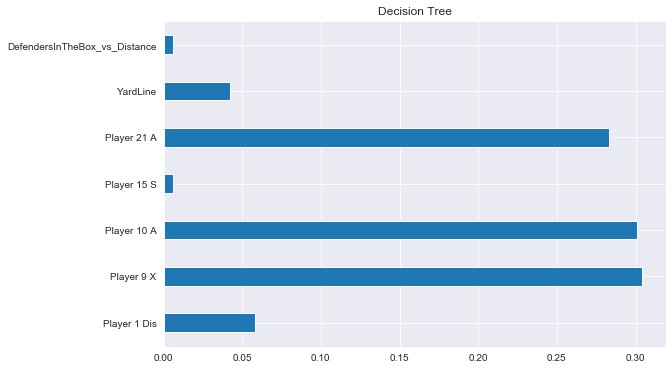

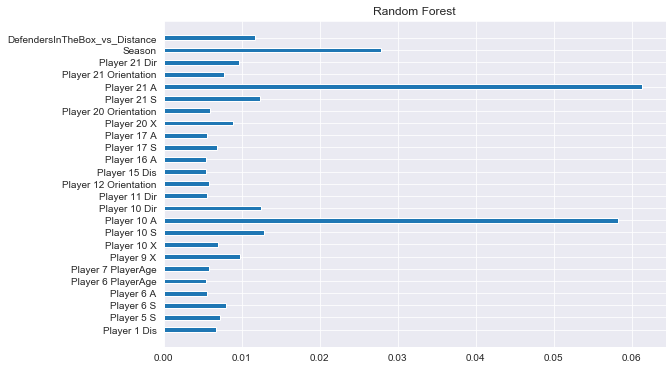

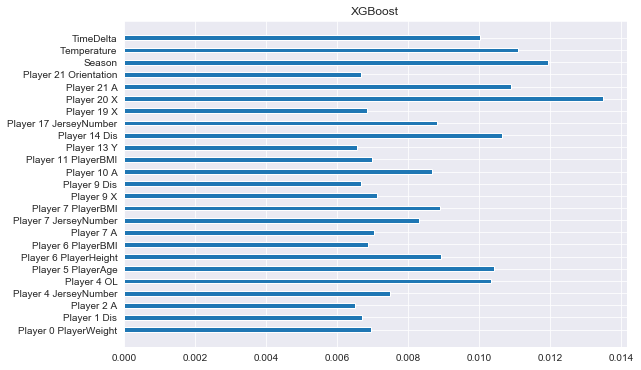

In [264]:
percentile = 95
eps = 1e-3

all_importances = []
for model_name, model in models.items():
    if hasattr(model, "feature_importances_"):
        importances = {"Model" : model_name}
        threshold = np.percentile(model.feature_importances_, percentile, interpolation="higher")
        threshold = threshold or eps
        indices = np.where(model.feature_importances_ >= threshold)[0]
        for index in indices:
            importances[X_columns[index]] = model.feature_importances_[index]
        all_importances.append(importances)
        plt.figure(figsize=(9,6))
        plt.barh(
            np.arange(len(indices)),
            model.feature_importances_[indices], 
            tick_label=X_columns[indices],
            height=0.4
           )
        plt.title(model_name)
        plt.show()

In [265]:
pd.DataFrame(all_importances)

,Model,Player 1 Dis,Player 9 X,Player 10 A,Player 15 S,Player 21 A,YardLine,DefendersInTheBox_vs_Distance,Player 5 S,Player 6 S,...,Player 7 JerseyNumber,Player 7 PlayerBMI,Player 9 Dis,Player 11 PlayerBMI,Player 13 Y,Player 14 Dis,Player 17 JerseyNumber,Player 19 X,Temperature,TimeDelta
0,Decision Tree,0.057997,0.304016,0.301117,0.005892,0.283033,0.041953,0.005991,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Random Forest,0.006684,0.009762,0.058306,NaN,0.061318,NaN,0.011772,0.00718,0.008033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,XGBoost,0.006690,0.007120,0.008667,NaN,0.010902,NaN,NaN,NaN,NaN,...,0.008285,0.008889,0.006677,0.006973,0.00654,0.010635,0.008794,0.006832,0.011095,0.010029


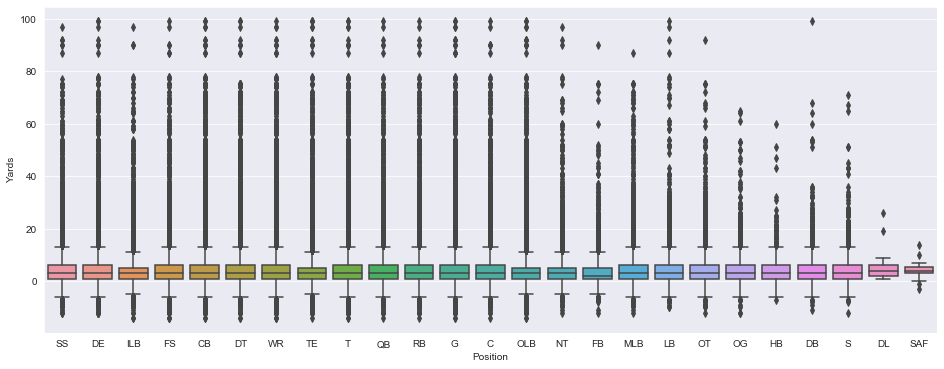

In [150]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="Position", y="Yards", data=train)

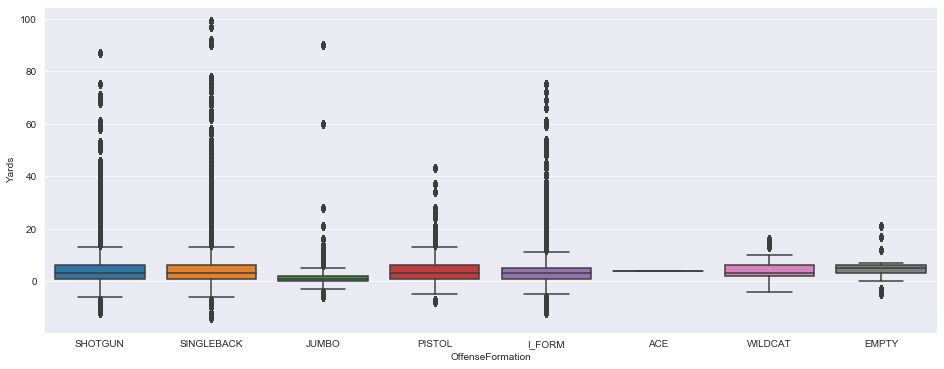

In [149]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="OffenseFormation", y="Yards", data=train)

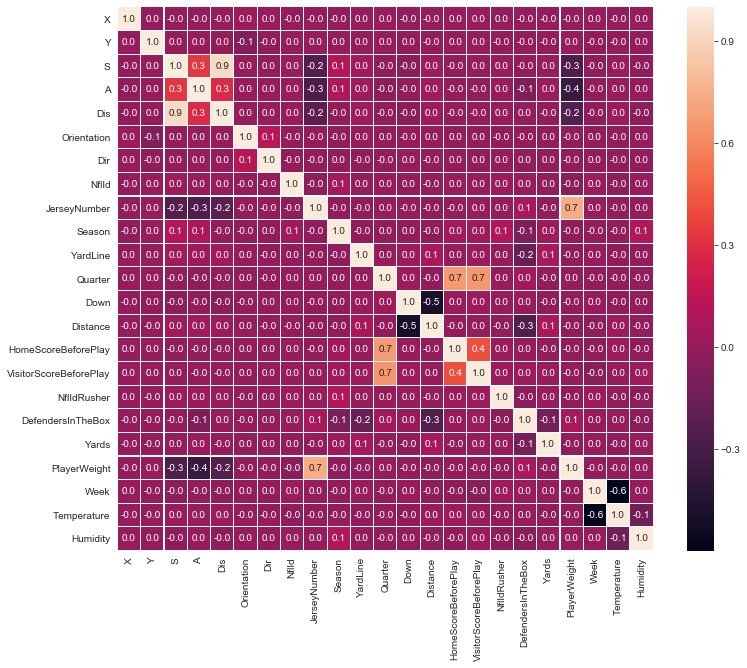

In [148]:
f,ax = plt.subplots(figsize=(12,10))
sns.heatmap(train.iloc[:,2:].corr(),annot=True, linewidths=.1, fmt='.1f', ax=ax)

plt.show()
